In [1]:
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Deal with the Training Data (Most from the sample code)
train_df = pd.read_csv('train.csv', header=0)        # Load the train file into a dataframe

# I need to convert all strings to integer classifiers.
# I need to fill in the missing values of the data and make it complete.

# female = 0, Male = 1
train_df['Gender'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Embarked from 'C', 'Q', 'S'
# Note this is not ideal: in translating categories to numbers, Port "2" is not 2 times greater than Port "1", etc.

# All missing Embarked -> just make them embark from most common place
if len(train_df.Embarked[ train_df.Embarked.isnull() ]) > 0:
    train_df['Embarked'].fillna(train_df.Embarked.dropna().value_counts().idxmax(), inplace=True)

Ports = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,
Ports_dict = { name : i for i, name in Ports }              # set up a dictionary in the form  Ports : index
train_df.Embarked = train_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int

# All the ages with no data -> make the median of all Ages
median_age = train_df['Age'].dropna().median()
if len(train_df.Age[ train_df.Age.isnull() ]) > 0:
    train_df.loc[ (train_df.Age.isnull()), 'Age'] = median_age

# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
train_df = train_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

In [3]:
# extract data
train_data = train_df.values
train_x = train_data[0::,1::]
train_y = train_data[0::,0]

In [4]:
# feature importance
col_names = np.array(train_df.columns.values)
forest = RandomForestClassifier(n_estimators=100)
forest.fit(train_x, train_y)
importance = np.array(forest.feature_importances_)
impo_colName = np.vstack([col_names[1:], importance])
ind = impo_colName[1,:].argsort()
ind = ind[::-1]
print impo_colName[:,ind].T

[['Fare' 0.27954943947553657]
 ['Gender' 0.2601041309604243]
 ['Age' 0.25674057475494055]
 ['Pclass' 0.08481302268891362]
 ['SibSp' 0.04765861388675205]
 ['Parch' 0.038331594654609835]
 ['Embarked' 0.032802623578823076]]


## From the feature importance test we can know the most three important features are Fare, Gender and Age

In [5]:
# Do OOB test to find the parameters based on current features
# oob
RANDOM_STATE = 5566  # a seed number which will affect the final parameters choice.
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

the min val is 0.159371492705 as 8 in label: RandomForestClassifier, max_features='sqrt'
the min val is 0.159371492705 as 8 in label: RandomForestClassifier, max_features='log2'
the min val is 0.161616161616 as 10 in label: RandomForestClassifier, max_features=None


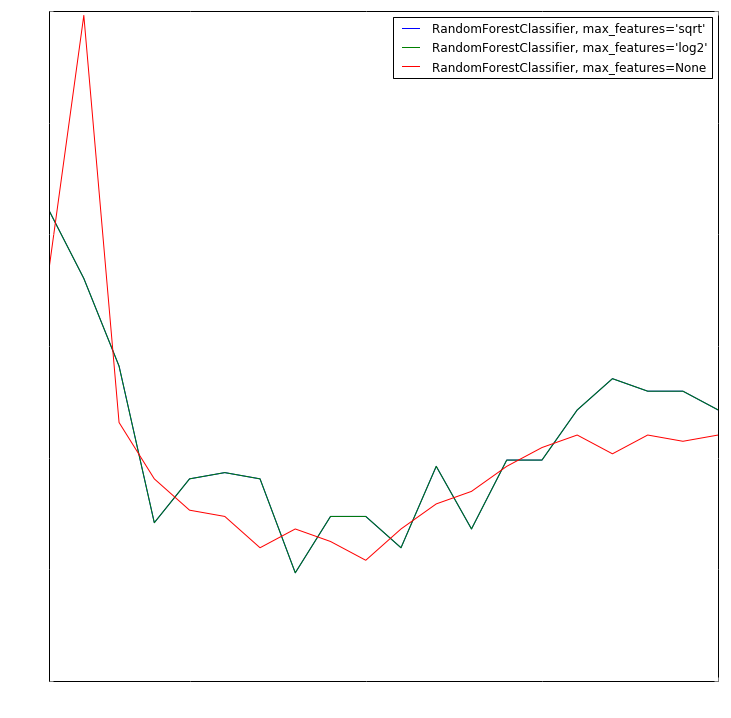

In [6]:
ensemble_clfs_deep = ensemble_clfs
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs_deep)

# Range of `n_estimators` values to explore.
min_max_depth = 1
max_max_depth = 20

for label, clf in ensemble_clfs_deep:
    clf.set_params(warm_start=False)
    clf.set_params(n_estimators=100)
    for i in range(min_max_depth, max_max_depth + 1):
        clf.set_params(max_depth=i)
        clf.fit(train_x, train_y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ys_np = np.array(ys)
    xs_np = np.array(xs)
    val = np.min(ys_np)
    n = xs_np[ys.index(val)]
    print "the min val is {} as {} in label: {}".format(val, n, label)
    plt.plot(xs, ys, label=label)
plt.xlim(min_max_depth, max_max_depth)
plt.xlabel("n_max_depth")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.show()

the min val is 0.158249158249 as 87 in label: RandomForestClassifier, max_features='sqrt'
the min val is 0.158249158249 as 87 in label: RandomForestClassifier, max_features='log2'
the min val is 0.158249158249 as 79 in label: RandomForestClassifier, max_features=None


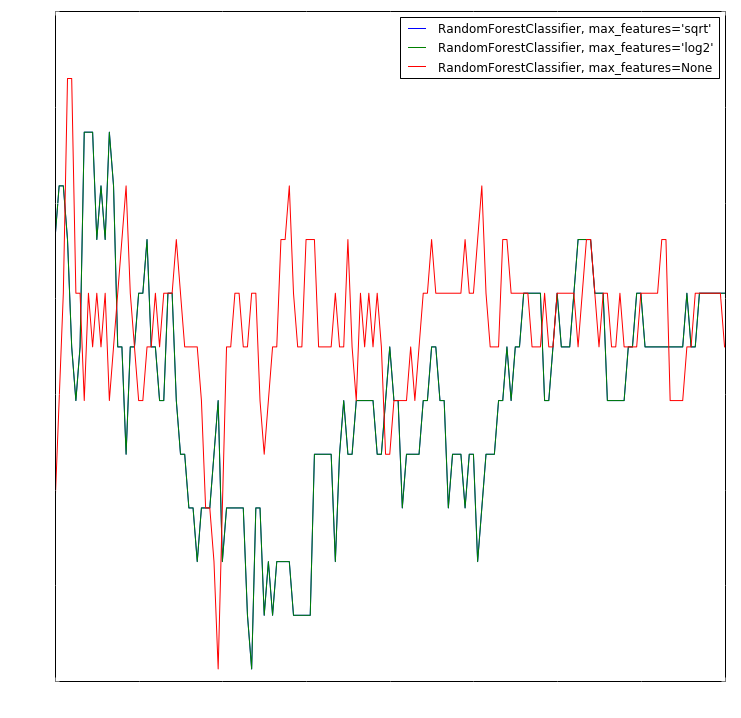

In [8]:
ensemble_clfs_n = ensemble_clfs
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs_n)

# Range of `n_estimators` values to explore.
min_estimators = 40
max_estimators = 200

for label, clf in ensemble_clfs_n:
    clf.set_params(max_depth=8)
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(train_x, train_y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ys_np = np.array(ys)
    xs_np = np.array(xs)
    val = np.min(ys_np)
    n = xs_np[ys.index(val)]
    print "the min val is {} as {} in label: {}".format(val, n, label)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.show()

## So I choose max_feature: log2, n_estimator: 87, max_deep:8 in RANDOM_STATE = 5566

In [9]:
forest = RandomForestClassifier(n_estimators=87, max_depth=8, max_features='log2', random_state=5566)
score = cross_validation.cross_val_score(forest, train_x, train_y, cv=10)

In [10]:
print "the max score is {}".format(np.max(score))
print "the min score is {}".format(np.min(score))
print "the avg score is {}".format(np.mean(score))

the max score is 0.932584269663
the min score is 0.741573033708
the avg score is 0.828385824538


### test